In [1]:
#import needed modules
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# The following line improves formatting when ouputting NumPy arrays.
np.set_printoptions(linewidth = 200)

In [2]:
#load the data already in keras. 
#ELse data can be get at Yann Lecun website: http://yann.lecun.com/exdb/mnist/ (
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
#@title Double-click to see a solution to Task 1. 
x_train_normalized = x_train / 255.0
x_test_normalized = x_test / 255.0
print(x_train_normalized[2900][10]) # Output a normalized row

[0.         0.         0.         0.         0.         0.         0.         0.55294118 1.         0.66666667 0.11372549 0.         0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.         0.         0.         0.         0.        ]


In [4]:
#@title Define the plotting function
def plot_curve(title,epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")
  plt.title(title)

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Loaded the plot_curve function.")

Loaded the plot_curve function.


In [7]:
"""def create_model(my_learning_rate):
    c#reate and compile a deep neural net.
    model = tf.keras.models.Sequential()

    # The features are stored in a two-dimensional 28X28 array. 
    # Flatten that two-dimensional array into a one-dimensional 
    # 784-element array.
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

    # Define the first hidden layer.   
    model.add(tf.keras.layers.Dense(units=32, activation='relu'))

    # Define a dropout regularization layer. 
    model.add(tf.keras.layers.Dropout(rate=0.2))

    # Define the output layer. It had 10 units because we have 10 classes
    model.add(tf.keras.layers.Dense(units=10, activation='softmax'))     

    # compile the model to use it. We use Adam as optimizer and sparse_categorical_crossentropy because
    # we have a multi-class classification
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])

    return model     """

'def create_model(my_learning_rate):\n    c#reate and compile a deep neural net.\n    model = tf.keras.models.Sequential()\n\n    # The features are stored in a two-dimensional 28X28 array. \n    # Flatten that two-dimensional array into a one-dimensional \n    # 784-element array.\n    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))\n\n    # Define the first hidden layer.   \n    model.add(tf.keras.layers.Dense(units=32, activation=\'relu\'))\n\n    # Define a dropout regularization layer. \n    model.add(tf.keras.layers.Dropout(rate=0.2))\n\n    # Define the output layer. It had 10 units because we have 10 classes\n    model.add(tf.keras.layers.Dense(units=10, activation=\'softmax\'))     \n\n    # compile the model to use it. We use Adam as optimizer and sparse_categorical_crossentropy because\n    # we have a multi-class classification\n    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),\n                loss="sparse_categorical_crossentro

In [8]:
d_optimizer={"SGD" : lambda  l: tf.keras.optimizers.SGD(learning_rate=l),
"RMSprop" : lambda  l: tf.keras.optimizers.RMSprop(learning_rate=l),
"Adam" : lambda  l: tf.keras.optimizers.Adam(learning_rate=l),
"AdamW" : lambda  l: tf.keras.optimizers.AdamW(learning_rate=l),
"Adadelta" : lambda  l: tf.keras.optimizers.Adadelta(learning_rate=l),
"Adagrad" : lambda  l: tf.keras.optimizers.Adagrad(learning_rate=l),
"Adamax" : lambda  l: tf.keras.optimizers.Adamax(learning_rate=l),
"Adafactor" : lambda  l: tf.keras.optimizers.Adafactor(learning_rate=l),
"Nadam" : lambda  l: tf.keras.optimizers.Nadam(learning_rate=l),
"Ftrl" : lambda  l: tf.keras.optimizers.Ftrl(learning_rate=l)}

def create_optimizer(name, learning_rate):
    return d_optimizer.get(name)(learning_rate)

In [13]:
def create_layer(k, dict_layer,model):
    param = dict_layer.get(k)
    model.add(tf.keras.layers.Dense(units=param.get("nb_node"), activation=param.get("activation")))
    # Define a dropout regularization layer. 
    model.add(tf.keras.layers.Dropout(rate=param.get("drop_out_rate")))
    return model

def create_model(dict_layer:dict, optimizer:str, loss:str, learning_rate, metrics:list):
    """Create and compile a deep neural net."""
    """key of dict_layer must be in the form {1 : {param1}, 2 : {param1} 
        with 1 being layer 1, 2 being layer 2, etc. param has the key values
        "activation" : "activation_function_name"
        "nb_node" : nb_node
        "drop_out_rate" : drop_out_rate_value (not use for the last layer)  """
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    # The features are stored in a two-dimensional 28X28 array. 
    # Flatten that two-dimensional array into a one-dimensional 
    # 784-element array.
    print(list(dict_layer))
    for k in range(1,len(dict_layer)):
        model=create_layer(k,dict_layer,model)
    param=dict_layer.get(len(dict_layer))
    # Define the output layer. It had 10 units because we have 10 classes
    model.add(tf.keras.layers.Dense(param.get("nb_node"), activation=param.get("activation")))     

    # compile the model to use it. We use Adam as optimizer and sparse_categorical_crossentropy because
    # we have a multi-class classification
    model.compile(optimizer=create_optimizer(optimizer,learning_rate=learning_rate),
                    loss=loss,
                    metrics=metrics)
    return model    

In [14]:
def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=0.1, verbose=2):
  """Train the model by feeding it data."""

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, 
                      validation_split=validation_split, verbose = verbose)
 
  # To track the progression of training, gather a snapshot
  # of the model's metrics at each epoch. 
  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return model, epochs, hist    

In [15]:
def test_model(dict_layer, optimizer, loss, learning_rate, metrics,
                   epochs, batch_size, validation_split, verbose):
    my_model = create_model(dict_layer = layers, 
                            optimizer = "Adam",
                            loss="sparse_categorical_crossentropy",
                            learning_rate=learning_rate,
                            metrics=['accuracy'])
    # Train the model on the normalized training set.
    print(list(my_model.layers))
    my_model, epochs, hist = train_model(my_model, x_train_normalized, y_train, 
                               epochs, batch_size, validation_split, verbose = 0)

    # Plot a graph of the metric vs. epochs.
    title = ""
    for v in dict_layer.values():
        title += v.get("activation") + " + "
    title=title[:-2]
    list_of_metrics_to_plot = ['accuracy']
    print("------------ ",title," ------------" )
    plot_curve(title,epochs, hist, list_of_metrics_to_plot)

    # Evaluate against the test set.
    print("\n Evaluate the new model against the test set:")
    my_model.evaluate(x=x_test_normalized, y=y_test, batch_size=batch_size)

[1, 2, 3]
[<keras.layers.reshaping.flatten.Flatten object at 0x0000019ABFF37970>, <keras.layers.core.dense.Dense object at 0x0000019ABFF99040>, <keras.layers.regularization.dropout.Dropout object at 0x0000019ABFFA5E50>, <keras.layers.core.dense.Dense object at 0x0000019ABFFBBEB0>, <keras.layers.regularization.dropout.Dropout object at 0x0000019ABFFBF520>, <keras.layers.core.dense.Dense object at 0x0000019ABFFBF220>]
------------  relu   ------------

 Evaluate the new model against the test set:
10/10 [==============================] - 0s 17ms/step - loss: 0.0841 - accuracy: 0.9829
[1, 2, 3]
[<keras.layers.reshaping.flatten.Flatten object at 0x0000019ABFFD1D00>, <keras.layers.core.dense.Dense object at 0x0000019AC0568AC0>, <keras.layers.regularization.dropout.Dropout object at 0x0000019AC0568CD0>, <keras.layers.core.dense.Dense object at 0x0000019AC056CBE0>, <keras.layers.regularization.dropout.Dropout object at 0x0000019AC0569850>, <keras.layers.core.dense.Dense object at 0x0000019AC0

KeyboardInterrupt: 

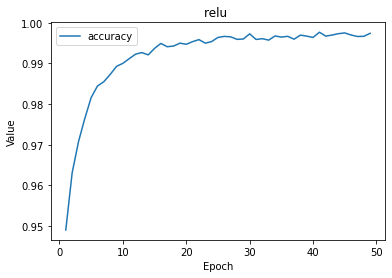

In [16]:
# The following variables are the hyperparameters.
learning_rate = 0.003
epochs = 50
batch_size = 1000
validation_split = 0.2

# Establish the model's topography.
#my_model = create_model(learning_rate)
layer_1_relu = {"activation" : "relu",
           "nb_node" : 10,
           "drop_out_rate" : 0.2}   
layer_1 = {"activation" : "relu",
           "nb_node" : 392,
           "drop_out_rate" : 0.2}    
layer_2 = {"activation" : "swish",
           "nb_node" : 98,
           "drop_out_rate" : 0.2}    
layer_3 = {"activation" : "softmax",
           "nb_node" : 10}    
layers= {1 : layer_1,2:layer_2, 3:layer_3}
 #(dict_layer,optimizer:str, loss:str, learning_rate, metrics:list)
arch = [{1:layer_1_relu},{1:layer_1,2:layer_3},{1 : layer_2,2:layer_3},{1 : layer_1,2:layer_2, 3:layer_3}]    

traintest = lambda dc : test_model(dict_layer = dc, optimizer = "Adam",
                                loss="sparse_categorical_crossentropy",
                                learning_rate=learning_rate,metrics=['accuracy'],
                                epochs=epochs, batch_size = batch_size, 
                                validation_split = validation_split,verbose = 0)
[traintest(dc) for dc in arch]
   


Relu alone is sufficient to have a good accuracy. But comratively to other architecture with only one layer it has many more nodes